# Project

## Problem Statement 

This project aims to recommend the best neighbourhood in New York to open a new restaurant. 


## Loading Libraries 

In [1]:
import pandas as pd
import numpy as np

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import requests
from bs4 import BeautifulSoup
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
#!conda install -c conda-forge folium

import os
import folium # map rendering library
# Matplotlib and associated plotting modules

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib as mp
import re
import csv
%matplotlib inline


print('Libraries imported.')

Libraries imported.


## Defining Important Functions

###### Neighborhoods using FourSquare API & New York City data that contains list Boroughs, Neighbourhoods along with their latitude and longitude.

In [2]:
def geo_location(address):
    # get the location of neighbourhoods
    geolocator = Nominatim(user_agent="ny_explorer")
    locatidn = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

Define a function to intract with FourSquare API and get top 100 venues within a radius of 1000 metres for a given latitude and longitude.

In [3]:
def get_venues(lat,lng):
    
    #set variables
    radius=1000
    LIMIT=100
    CLIENT_ID = 'AXBHZQVRDSD0JBH40OTYU2VUDZWJXHAA2OOMDJI51250N5GG'# Foursquare ID, note there is a daily call quota limit 
    CLIENT_SECRET ='QVQCW2H3CK50IC0LBA1IMVNJVMQ04WZJMDXPO314E54OZ20K' # Foursquare Secret, note there is a daily call quota limit
    VERSION = '20180605' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

 Define a function to get venue details like like count , rating , tip counts for a given venue id. to be used for ranking.

In [4]:
def get_venue_details(venue_id):
        
    CLIENT_ID = 'AXBHZQVRDSD0JBH40OTYU2VUDZWJXHAA2OOMDJI51250N5GG'# Foursquare ID, note there is a daily call quota limit 
    CLIENT_SECRET ='QVQCW2H3CK50IC0LBA1IMVNJVMQ04WZJMDXPO314E54OZ20K' # Foursquare Secret, note there is a daily call quota limit
    VERSION = '20180605' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

Define a funtion to get the New York city data such as Boroughs, Neighborhoods along with their latitude and longitude.

In [5]:
def get_ny_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    
    # define the dataframe columns
    col_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    ny_data = pd.DataFrame(columns=col_names)
    
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
    
        ny_data = ny_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
    return ny_data

## Data Exploration

In [6]:
# get new york data
ny_data=get_ny_data()
ny_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [7]:
ny_data.shape

(306, 4)

Based on the dataset, there are a total of 306 different Neighborhoods in New York.

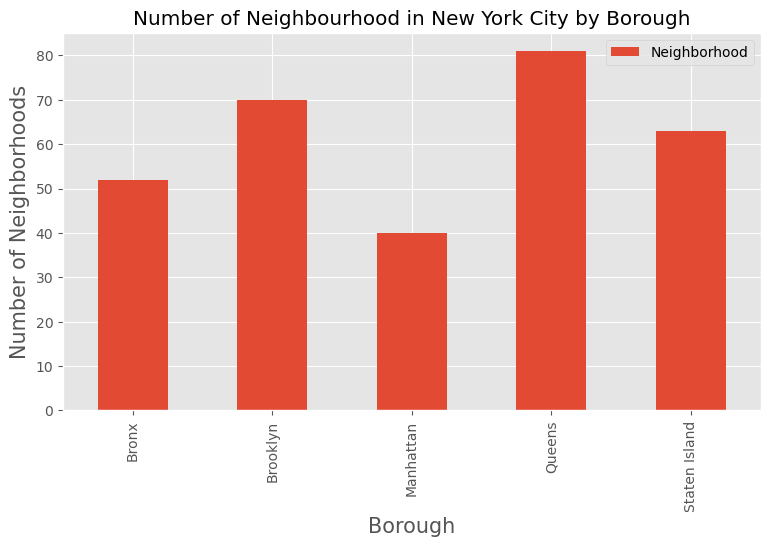

In [8]:
from matplotlib import pyplot as plt
plt.style.use('ggplot')

plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Neighbourhood in New York City by Borough')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('Number of Neighborhoods', fontsize=15)
#giving a bar plot
ny_data.groupby('Borough')['Neighborhood'].count().plot(kind='bar')
#legend
plt.legend()
plt.show()



Based on the data, Queens is the most densely populated borough in New York City with 80 neighborhoods

In [9]:
# prepare neighborhood list that contains indian restaurant
col_names=['Borough', 'Neighborhood', 'ID','Name']
indian_restaurant_ny=pd.DataFrame(columns=col_names)
count=1
for row in ny_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    indian_restaurants=venues[venues['Category']=='Indian Restaurant']   
    print('(',count,'/',len(ny_data),')','Indian Restaurants in '+Neighborhood+', '+Borough+':'+str(len(indian_restaurants)))
    for restaurant_detail in indian_restaurants.values.tolist():
        id, name , category=restaurant_detail
        indian_restaurant_ny = indian_restaurant_ny.append({'Borough': Borough,
                                                            'Neighborhood': Neighborhood, 
                                                            'ID': id,
                                                            'Name' : name
                                                           }, ignore_index=True)
    count+=1

( 1 / 306 ) Indian Restaurants in Wakefield, Bronx:0
( 2 / 306 ) Indian Restaurants in Co-op City, Bronx:0
( 3 / 306 ) Indian Restaurants in Eastchester, Bronx:0
( 4 / 306 ) Indian Restaurants in Fieldston, Bronx:0
( 5 / 306 ) Indian Restaurants in Riverdale, Bronx:0
( 6 / 306 ) Indian Restaurants in Kingsbridge, Bronx:0
( 7 / 306 ) Indian Restaurants in Marble Hill, Manhattan:0
( 8 / 306 ) Indian Restaurants in Woodlawn, Bronx:1
( 9 / 306 ) Indian Restaurants in Norwood, Bronx:0
( 10 / 306 ) Indian Restaurants in Williamsbridge, Bronx:0
( 11 / 306 ) Indian Restaurants in Baychester, Bronx:0
( 12 / 306 ) Indian Restaurants in Pelham Parkway, Bronx:0
( 13 / 306 ) Indian Restaurants in City Island, Bronx:0
( 14 / 306 ) Indian Restaurants in Bedford Park, Bronx:0
( 15 / 306 ) Indian Restaurants in University Heights, Bronx:0
( 16 / 306 ) Indian Restaurants in Morris Heights, Bronx:0
( 17 / 306 ) Indian Restaurants in Fordham, Bronx:0
( 18 / 306 ) Indian Restaurants in East Tremont, Bronx:

( 141 / 306 ) Indian Restaurants in Sunnyside, Queens:1
( 142 / 306 ) Indian Restaurants in East Elmhurst, Queens:0
( 143 / 306 ) Indian Restaurants in Maspeth, Queens:0
( 144 / 306 ) Indian Restaurants in Ridgewood, Queens:1
( 145 / 306 ) Indian Restaurants in Glendale, Queens:0
( 146 / 306 ) Indian Restaurants in Rego Park, Queens:1
( 147 / 306 ) Indian Restaurants in Woodhaven, Queens:0
( 148 / 306 ) Indian Restaurants in Ozone Park, Queens:0
( 149 / 306 ) Indian Restaurants in South Ozone Park, Queens:0
( 150 / 306 ) Indian Restaurants in College Point, Queens:0
( 151 / 306 ) Indian Restaurants in Whitestone, Queens:0
( 152 / 306 ) Indian Restaurants in Bayside, Queens:3
( 153 / 306 ) Indian Restaurants in Auburndale, Queens:0
( 154 / 306 ) Indian Restaurants in Little Neck, Queens:0
( 155 / 306 ) Indian Restaurants in Douglaston, Queens:0
( 156 / 306 ) Indian Restaurants in Glen Oaks, Queens:4
( 157 / 306 ) Indian Restaurants in Bellerose, Queens:0
( 158 / 306 ) Indian Restaurants

( 276 / 306 ) Indian Restaurants in Stuyvesant Town, Manhattan:1
( 277 / 306 ) Indian Restaurants in Flatiron, Manhattan:0
( 278 / 306 ) Indian Restaurants in Sunnyside Gardens, Queens:0
( 279 / 306 ) Indian Restaurants in Blissville, Queens:1
( 280 / 306 ) Indian Restaurants in Fulton Ferry, Brooklyn:0
( 281 / 306 ) Indian Restaurants in Vinegar Hill, Brooklyn:0
( 282 / 306 ) Indian Restaurants in Weeksville, Brooklyn:0
( 283 / 306 ) Indian Restaurants in Broadway Junction, Brooklyn:1
( 284 / 306 ) Indian Restaurants in Dumbo, Brooklyn:0
( 285 / 306 ) Indian Restaurants in Manor Heights, Staten Island:0
( 286 / 306 ) Indian Restaurants in Willowbrook, Staten Island:0
( 287 / 306 ) Indian Restaurants in Sandy Ground, Staten Island:0
( 288 / 306 ) Indian Restaurants in Egbertville, Staten Island:0
( 289 / 306 ) Indian Restaurants in Roxbury, Queens:0
( 290 / 306 ) Indian Restaurants in Homecrest, Brooklyn:0
( 291 / 306 ) Indian Restaurants in Middle Village, Queens:0
( 292 / 306 ) India

In [10]:
indian_restaurant_ny.head()

,Borough,Neighborhood,ID,Name
0,Bronx,Woodlawn,4c0448d9310fc9b6bf1dc761,Curry Spot
1,Bronx,Parkchester,4c194631838020a13e78e561,Melanies Roti Bar And Grill
2,Bronx,Spuyten Duyvil,4c04544df423a593ac83d116,Cumin Indian Cuisine
3,Bronx,Concourse,551b7f75498e86c00a0ed2e1,Hungry Bird
4,Bronx,Unionport,4c194631838020a13e78e561,Melanies Roti Bar And Grill


In [11]:
indian_restaurant_ny.shape

(152, 4)

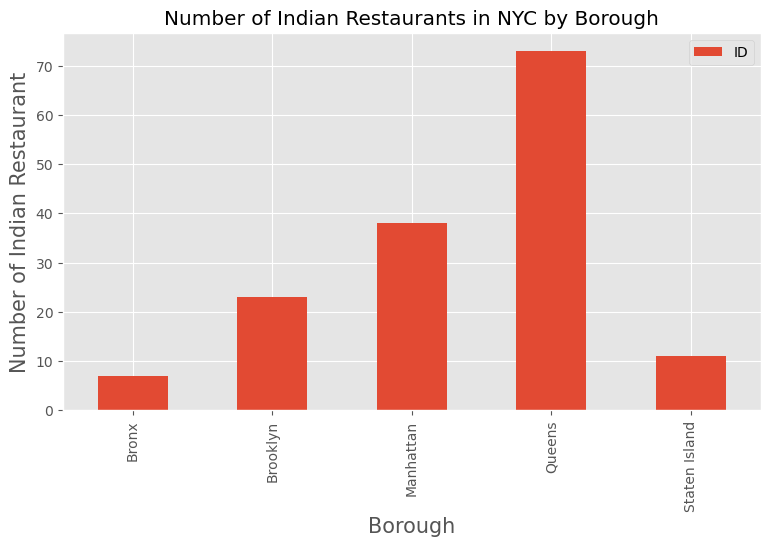

In [12]:
from matplotlib import pyplot as plt
plt.style.use('ggplot')

plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Indian Restaurants in NYC by Borough')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('Number of Indian Restaurant', fontsize=15)
#giving a bar plot
indian_restaurant_ny.groupby('Borough')['ID'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

It is noted that Queens has the highest number of Indian Restaurants.

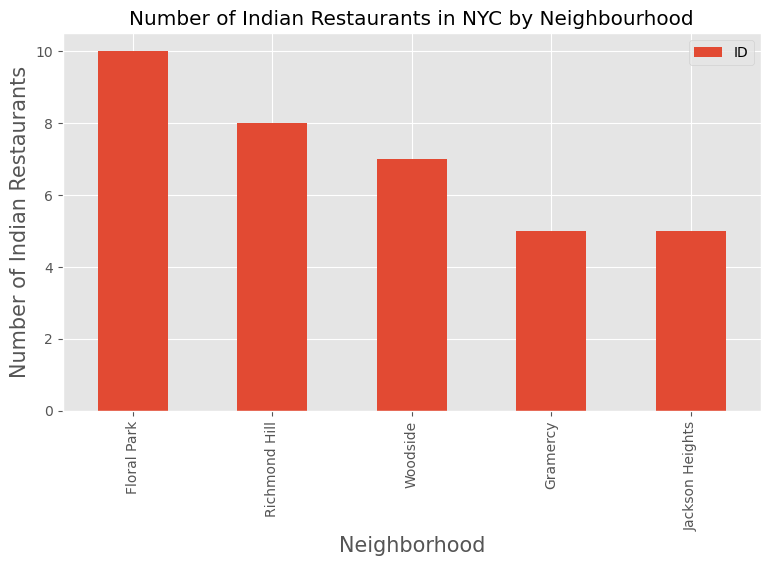

In [13]:
from matplotlib import pyplot as plt
plt.style.use('ggplot')

plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Indian Restaurants in NYC by Neighbourhood')
#On x-axis
plt.xlabel('Neighborhood', fontsize = 15)
#On y-axis
plt.ylabel('Number of Indian Restaurants', fontsize=15)
#giving a bar plot
indian_restaurant_ny.groupby('Neighborhood')['ID'].count().nlargest(5).plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

Floral Park in Queens has the most Indian Restaurants with a total count of 11.

In [14]:
indian_restaurant_ny[indian_restaurant_ny['Neighborhood']=='Floral Park']

,Borough,Neighborhood,ID,Name
102,Queens,Floral Park,4e4e3e22bd4101d0d7a5c2d1,Kerala Kitchen
103,Queens,Floral Park,4b647b56f964a520c4b62ae3,Usha Foods & Usha Sweets
104,Queens,Floral Park,527ffc0811d2d329d5e49abd,Jackson Diner
105,Queens,Floral Park,4b787c49f964a5209cd12ee3,Santoor Indian Restaurant
106,Queens,Floral Park,4c0c01e0bbc676b00d6b4cd5,Mumbai Xpress
107,Queens,Floral Park,4c76ff35a5676dcb72671721,Flavor Of India
108,Queens,Floral Park,4df0f39dd4c04d0392c853ea,Sagar Chinese
109,Queens,Floral Park,4cc642ed306e224b5bf2a76c,Shahi Darbar
110,Queens,Floral Park,55d68c1b498ecf05fa196fe1,Namaste Restaurant and Cafe
111,Queens,Floral Park,4e6bfe1c7d8b2c711b17bbe5,Surya sweets and snacks


In [15]:
# prepare neighborhood list that contains indian restaurants
col_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
indian_restaurant_stats_ny=pd.DataFrame(columns=col_names)
count=1


for row in indian_restaurant_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row

    # prepare neighborhood list that contains indian restaurants
col_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
indian_restaurant_stats_ny=pd.DataFrame(columns=col_names)
count=1


for row in indian_restaurant_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except (IndexError, KeyError) as e:
        print('No data available for id=',ID)
        # we will assign 0 value for these restaurants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(indian_restaurant_ny),')','processed')
    indian_restaurant_stats_ny = indian_restaurant_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1

                         ID        Name  Likes  Rating  Tips
0  4c0448d9310fc9b6bf1dc761  Curry Spot      5     7.3    10
( 1 / 152 ) processed
                         ID                         Name  Likes  Rating  Tips
0  4c194631838020a13e78e561  Melanies Roti Bar And Grill      3     5.9     2
( 2 / 152 ) processed
                         ID                  Name  Likes  Rating  Tips
0  4c04544df423a593ac83d116  Cumin Indian Cuisine     13     6.2     9
( 3 / 152 ) processed
                         ID         Name  Likes  Rating  Tips
0  551b7f75498e86c00a0ed2e1  Hungry Bird      8     7.0     3
( 4 / 152 ) processed
                         ID                         Name  Likes  Rating  Tips
0  4c194631838020a13e78e561  Melanies Roti Bar And Grill      3     5.9     2
( 5 / 152 ) processed
Empty DataFrame
Columns: [ID, Name, Likes, Rating, Tips]
Index: []
No data available for id= 55dfa36a498e164ef19bef7b
( 6 / 152 ) processed
                         ID          Name  Likes  

No data available for id= 4c7060e734443704ca0e245f
( 58 / 152 ) processed
No data available for id= 4b998d3ff964a520fc8235e3
( 59 / 152 ) processed
No data available for id= 5da4fbf091a08400078be19d
( 60 / 152 ) processed
No data available for id= 4b189424f964a52043d423e3
( 61 / 152 ) processed
No data available for id= 49ebb18ff964a52016671fe3
( 62 / 152 ) processed
No data available for id= 4e334b7bb0fb17f64f81a8b2
( 63 / 152 ) processed
No data available for id= 527d9cbc498edf0db10bde6b
( 64 / 152 ) processed
No data available for id= 4b998d3ff964a520fc8235e3
( 65 / 152 ) processed
No data available for id= 5da4fbf091a08400078be19d
( 66 / 152 ) processed
No data available for id= 4afdcf29f964a520162b22e3
( 67 / 152 ) processed
No data available for id= 49ebb18ff964a52016671fe3
( 68 / 152 ) processed
No data available for id= 5da4fbf091a08400078be19d
( 69 / 152 ) processed
No data available for id= 527d9cbc498edf0db10bde6b
( 70 / 152 ) processed
No data available for id= 49ebb18ff964

In [16]:
indian_restaurant_stats_ny.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,Woodlawn,4c0448d9310fc9b6bf1dc761,Curry Spot,5,7.3,10
1,Bronx,Parkchester,4c194631838020a13e78e561,Melanies Roti Bar And Grill,3,5.9,2
2,Bronx,Spuyten Duyvil,4c04544df423a593ac83d116,Cumin Indian Cuisine,13,6.2,9
3,Bronx,Concourse,551b7f75498e86c00a0ed2e1,Hungry Bird,8,7.0,3
4,Bronx,Unionport,4c194631838020a13e78e561,Melanies Roti Bar And Grill,3,5.9,2


In [17]:
indian_restaurant_ny.shape

(152, 4)

In [18]:
indian_restaurant_stats_ny.to_csv('indian_restaurant_stats_ny.csv', index=False)

In [19]:
indian_restaurant_stats_ny_csv=pd.read_csv('indian_restaurant_stats_ny.csv')

In [20]:
indian_restaurant_stats_ny_csv.shape

(152, 7)

In [21]:
indian_restaurant_stats_ny_csv.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,Woodlawn,4c0448d9310fc9b6bf1dc761,Curry Spot,5,7.3,10
1,Bronx,Parkchester,4c194631838020a13e78e561,Melanies Roti Bar And Grill,3,5.9,2
2,Bronx,Spuyten Duyvil,4c04544df423a593ac83d116,Cumin Indian Cuisine,13,6.2,9
3,Bronx,Concourse,551b7f75498e86c00a0ed2e1,Hungry Bird,8,7.0,3
4,Bronx,Unionport,4c194631838020a13e78e561,Melanies Roti Bar And Grill,3,5.9,2


In [22]:
indian_restaurant_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 152 entries, 0 to 151
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Borough       152 non-null    object 
 1   Neighborhood  152 non-null    object 
 2   ID            152 non-null    object 
 3   Name          152 non-null    object 
 4   Likes         152 non-null    object 
 5   Rating        152 non-null    float64
 6   Tips          152 non-null    object 
dtypes: float64(1), object(6)
memory usage: 8.4+ KB


## Data Preparation

In [23]:
indian_restaurant_stats_ny['Likes']=indian_restaurant_stats_ny['Likes'].astype('float64')

In [24]:
indian_restaurant_stats_ny['Tips']=indian_restaurant_stats_ny['Tips'].astype('float64')

In [25]:
indian_restaurant_stats_ny['Rating']=indian_restaurant_stats_ny['Rating'].astype('float64')

In [26]:
indian_restaurant_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 152 entries, 0 to 151
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Borough       152 non-null    object 
 1   Neighborhood  152 non-null    object 
 2   ID            152 non-null    object 
 3   Name          152 non-null    object 
 4   Likes         152 non-null    float64
 5   Rating        152 non-null    float64
 6   Tips          152 non-null    float64
dtypes: float64(3), object(4)
memory usage: 8.4+ KB


In [27]:
# Restaurants with maximum Likes
indian_restaurant_stats_ny.iloc[indian_restaurant_stats_ny['Likes'].idxmax()]

Borough                        Manhattan
Neighborhood                     Midtown
ID              49d91c12f964a520015e1fe3
Name               The Kati Roll Company
Likes                                834
Rating                               8.6
Tips                                 256
Name: 37, dtype: object

In [28]:
# Restaurants with maximum Rating
indian_restaurant_stats_ny.iloc[indian_restaurant_stats_ny['Rating'].idxmax()]

Borough                        Manhattan
Neighborhood                     Tribeca
ID              4bbb9dbded7776b0e1ad3e51
Name                    Tamarind TriBeCa
Likes                                601
Rating                               9.1
Tips                                 151
Name: 40, dtype: object

In [29]:
# Restaurants with maximum Tips
indian_restaurant_stats_ny.iloc[indian_restaurant_stats_ny['Tips'].idxmax()]

Borough                        Manhattan
Neighborhood                     Midtown
ID              49d91c12f964a520015e1fe3
Name               The Kati Roll Company
Likes                                834
Rating                               8.6
Tips                                 256
Name: 37, dtype: object

In [30]:
ny_neighborhood_stats=indian_restaurant_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']

In [31]:
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

,Neighborhood,Average Rating
70,Tribeca,9.1
54,Prospect Heights,8.9
75,West Village,8.8
55,Prospect Lefferts Gardens,8.8
12,Chelsea,8.8
21,East Village,8.7
46,Midtown,8.6
14,Clinton Hill,8.5
28,Fort Greene,8.5
62,Roosevelt Island,8.3


In [32]:
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head()

,Neighborhood,Average Rating
70,Tribeca,9.1
54,Prospect Heights,8.9
75,West Village,8.8
55,Prospect Lefferts Gardens,8.8
12,Chelsea,8.8


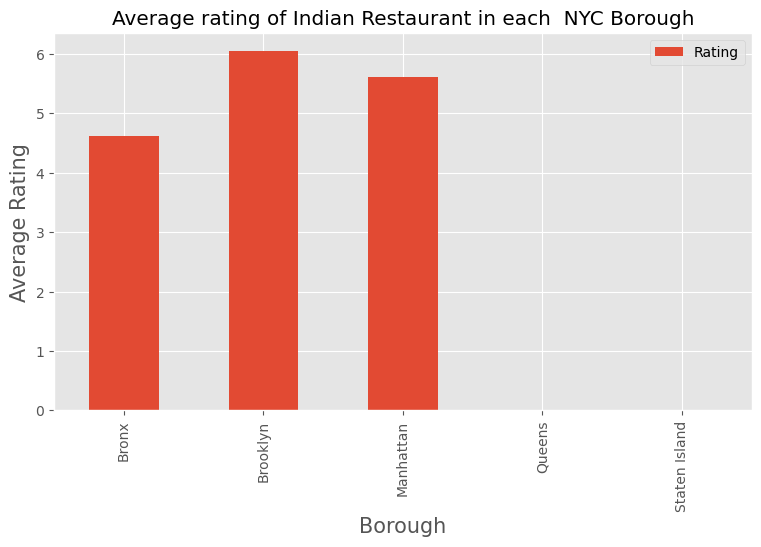

In [33]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Average rating of Indian Restaurant in each  NYC Borough')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('Average Rating', fontsize=15)
#giving a bar plot
indian_restaurant_stats_ny.groupby('Borough').mean()['Rating'].plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()


It could be interprested that Brooklyn has the highest average rating for Indian Restaurants and Data for Queens and Staten Island isn't available.


## Observation

###### All the neighborhoods with average rating greater or equal 8.0 to be visualized on map

In [34]:
ny_neighborhood_stats=ny_neighborhood_stats[ny_neighborhood_stats['Average Rating']>=8.0]
ny_neighborhood_stats 

,Neighborhood,Average Rating
11,Central Harlem,8.200000
12,Chelsea,8.800000
14,Clinton Hill,8.500000
19,East Flatbush,8.000000
21,East Village,8.700000
28,Fort Greene,8.500000
44,Manhattan Valley,8.050000
46,Midtown,8.600000
48,Morningside Heights,8.000000
51,Ocean Hill,8.050000


In [35]:
ny_neighborhood_stats=pd.merge(ny_neighborhood_stats,ny_data, on='Neighborhood')
ny_neighborhood_stats=ny_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

,Borough,Neighborhood,Latitude,Longitude,Average Rating
15,Manhattan,Tribeca,40.721522,-74.010683,9.1
11,Brooklyn,Prospect Heights,40.676822,-73.964859,8.9
2,Staten Island,Chelsea,40.594726,-74.189560,8.8
17,Manhattan,West Village,40.734434,-74.006180,8.8
1,Manhattan,Chelsea,40.744035,-74.003116,8.8
12,Brooklyn,Prospect Lefferts Gardens,40.658420,-73.954899,8.8
5,Manhattan,East Village,40.727847,-73.982226,8.7
8,Manhattan,Midtown,40.754691,-73.981669,8.6
3,Brooklyn,Clinton Hill,40.693229,-73.967843,8.5
6,Brooklyn,Fort Greene,40.688527,-73.972906,8.5


In [36]:
# create map and display it
ny_map = folium.Map(location=(40.693943, -73.985880), zoom_start=12)

In [37]:
# instantiate a feature group for the incidents in the dataframe
incidents = folium.map.FeatureGroup()

# loop through the 100 crimes and add each to the incidents feature group
for lat, lng, in ny_neighborhood_stats[['Latitude','Longitude']].values:
    incidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

In [38]:
ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighborhood']+', '+ny_neighborhood_stats['Borough']+'('+ny_neighborhood_stats['Average Rating'].map(str)+')'

##### Best neighbourhoods in New York that has highest average rating for Indian Restaurants.

In [39]:
# add pop-up text to each marker on the map
for lat, lng, label in ny_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
# add incidents to map
ny_map.add_child(incidents)

Findings 
1. Murray Hill, Tribeca, Midtown in Manhattan are some of the best neighborhoods for Indian cuisine. 
2. Bronx has the lowest rated Indian Restaurants in NYC.
3. Manhattan is the best place to stay if you prefer Indian Cuisine.

##### Recommendation

 Midtown or Tribeca in Manhattan would be the best choice to start a restaurant given that 
 1. it is the third most populous urban area in New York City (NYC).
 2. it has a population density of 27,826 people per square km, highest of any borough in the United States.
 3. it has some of the top rated Indian restaurants located in that area 
 4. It has the second highest Asian ethnic minority population in NYC.